In [1]:
from voc import Vocab
import matplotlib.pyplot as plt
import numpy as np
import torch
import re
import random

def readToken():
    with open('../dataset/time_machine.txt') as f:
        lines = f.readlines()
        tokens = [ re.sub('[^A-Za-z0-9]',' ',line) for line in lines]
    return tokens

lines = readToken()

In [2]:
def tokenize(lines,token='word'):
    if token == 'word':
        return [ line.split() for line in lines ]
    elif token == 'char':
        return [ list(line) for line in lines ]
    else:
        raise ValueError('格式错误')

tokens = tokenize(lines)

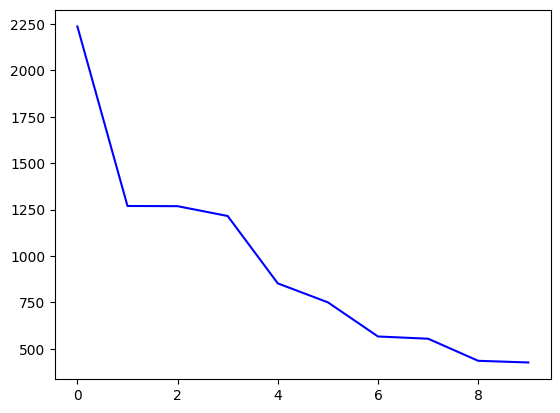

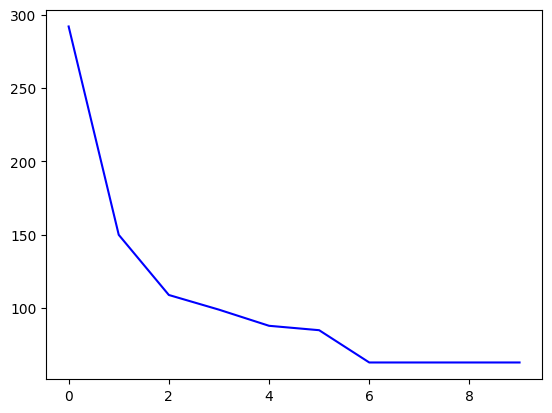

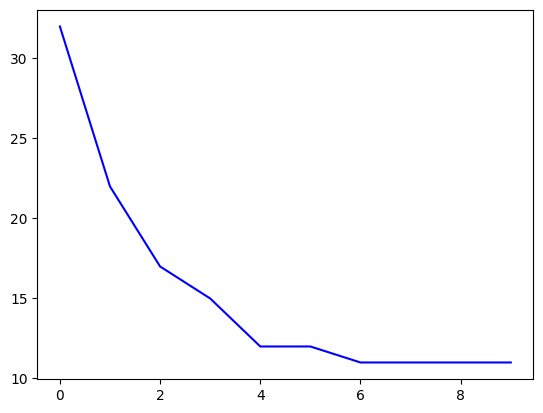

In [3]:
# test for the differ time step tokens freq
voc1 = Vocab(tokens)
token2 = [ [tk] for token in tokens for tk in zip(token[:-2],token[1:]) ]
voc2 = Vocab(token2)
token3 = [ [tk] for token in tokens for tk in zip(token[:-3],token[1:-2],token[2:]) ]
voc3 = Vocab(token3)
# print(voc3.token_freqs)
plt.plot(range(len(voc1.token_freqs[0:10])),[ freq for tk,freq in voc1.token_freqs[0:10] ],color='blue')
plt.show()

plt.plot(range(len(voc2.token_freqs[0:10])),[ freq for tk,freq in voc2.token_freqs[0:10] ],color='blue')
plt.show()

plt.plot(range(len(voc3.token_freqs[0:10])),[ freq for tk,freq in voc3.token_freqs[0:10] ],color='blue')
plt.show()

In [4]:
corpus = [ tk for token in tokens for tk in token ]
def seq_data_iter_random(corpus,batch_size,time_step):
    corpus = corpus[random.randint(0,time_step-1):]
    seq_nums = (len(corpus)-1) // time_step
    indices = corpus[:seq_nums*time_step:time_step]
    random.shuffle(indices)
    
    def get_data(indices):
        return corpus[indices:indices+time_step]
    print(indices)
    batch_nums = seq_nums // batch_size
    for i in range(0,batch_nums*batch_size,batch_size):
        initial_per_batches = indices[i:i+batch_size]
        X = [ get_data(j) for j in initial_per_batches ]
        Y = [ get_data(j+1) for j in initial_per_batches ]
        
        yield torch.tensor(X),torch.tensor(Y)

In [5]:
my_seq = list(range(35))
for X,Y in seq_data_iter_random(my_seq,2,5):
    print('X:',X,'\nY:',Y)

[26, 6, 11, 16, 1, 21]
X: tensor([[27, 28, 29, 30, 31],
        [ 7,  8,  9, 10, 11]]) 
Y: tensor([[28, 29, 30, 31, 32],
        [ 8,  9, 10, 11, 12]])
X: tensor([[12, 13, 14, 15, 16],
        [17, 18, 19, 20, 21]]) 
Y: tensor([[13, 14, 15, 16, 17],
        [18, 19, 20, 21, 22]])
X: tensor([[ 2,  3,  4,  5,  6],
        [22, 23, 24, 25, 26]]) 
Y: tensor([[ 3,  4,  5,  6,  7],
        [23, 24, 25, 26, 27]])


In [6]:
def seq_data_iter_sequential(corpus, batch_size, num_steps):  #@save
    """使用顺序分区生成一个小批量子序列"""
    # 从随机偏移量开始划分序列
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y

In [7]:
for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[ 4,  5,  6,  7,  8],
        [19, 20, 21, 22, 23]]) 
Y: tensor([[ 5,  6,  7,  8,  9],
        [20, 21, 22, 23, 24]])
X:  tensor([[ 9, 10, 11, 12, 13],
        [24, 25, 26, 27, 28]]) 
Y: tensor([[10, 11, 12, 13, 14],
        [25, 26, 27, 28, 29]])
X:  tensor([[14, 15, 16, 17, 18],
        [29, 30, 31, 32, 33]]) 
Y: tensor([[15, 16, 17, 18, 19],
        [30, 31, 32, 33, 34]])


In [8]:
class seqDataLoader:
    def __init__(self,batch_size,num_steps,is_random):
        self.num_steps = num_steps
        self.batch_size = batch_size
        if is_random:
            self.data_iter_fn = seq_data_iter_random
        else:
            self.data_iter_fn = seq_data_iter_sequential
        self.corpus = [ tk for token in tokenize(lines) for tk in token ]
    def __iter__(self):
        return self.data_iter_fn(self.corpus,self.batch_size,self.num_steps)